## Analyze A/B Test Results
### by Luyuan Zhang, June 22nd, 2018

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

import libraries.

In [50]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [51]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Find the number of rows in the dataset.

In [52]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [53]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [54]:
(df.converted==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [55]:
((df.group=='treatment') & (df.landing_page=='old_page')).sum()+ ((df.group=='control') & (df.landing_page=='new_page')).sum()

3893

f. Do any of the rows have missing values?

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values in any row

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  These rows need to be dropped.  

a. Create a new dataset **df2** with misaligned rows dropped.

In [57]:
#identify misaligned rows
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))

In [58]:
#extract rows where misgligned==False
df2=df.query('misaligned==False')

In [59]:
df2.shape

(290585, 6)

In [60]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [61]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [62]:
df2['user_id'].value_counts().sort_values(ascending=False).head()

773192    2
639032    1
663620    1
778364    1
645179    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [63]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,False


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [64]:
df2.drop(1899, axis=0, inplace=True)

C:\Users\lz233\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [65]:
df2.shape

(290584, 6)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [66]:
(df2['converted']==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [67]:
actual_pold=(df2.query('group=="control"')['converted']==1).mean()
actual_pold

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [68]:
actual_pnew=(df2.query('group=="treatment"')['converted']==1).mean()
actual_pnew

0.11880806551510564

d. What is the probability that an individual received the new page?

In [69]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

##### The difference between converted rate of control and treatment groups is very small. I am not convinced that one page leads to more conversions than other. More statistics are needed.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**null:** **$p_{old}$** - **$p_{new}$** >=0**

**alternative:** **$p_{old}$** - **$p_{new}$** <0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [70]:
pnew_null=(df2['converted']==1).mean()
pnew_null

0.11959708724499628

##### under the null, the **$p_{new}$** is 0.1197

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [71]:
pold_null=(df2['converted']==1).mean()
pold_null

0.11959708724499628

In [72]:
p_null=pnew_null

##### under the null, the **$p_{old}$** is also 0.1197

c. What is $n_{new}$?

In [73]:
n_new=(df2['landing_page']=='new_page').sum()
n_new

145310

##### The **$n_{new}$** is 145310

d. What is $n_{old}$?

In [74]:
n_old=(df2['landing_page']=='old_page').sum()
n_old

145274

##### The **$n_{old}$** is 145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [122]:
new_page_converted=np.random.binomial(n_new, p_null)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [76]:
old_page_converted=np.random.binomial(n_old, p_null)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [77]:
diff=new_page_converted/n_new-old_page_converted/n_old
diff

-0.0002843066238330111

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [78]:
p_diffs=[]
p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old   

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

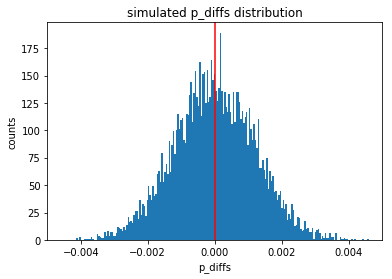

In [79]:
plt.hist(p_diffs, bins=200)
plt.xlim(-0.005, 0.005)
plt.xlabel('p_diffs')
plt.ylabel('counts')
plt.title('simulated p_diffs distribution')
plt.axvline(0.000, color='red');

##### This is what I expected. the center of p_diffs seem be at 0.000. In the simulation, pnew_null and pold_null are equal, so I would expect the center of p_diffs to be at 0. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [80]:
actual_diff=actual_pnew-actual_pold
actual_diff, actual_pnew, actual_pold

(-0.0015782389853555567, 0.11880806551510564, 0.1203863045004612)

In [81]:
actual_diff=actual_pnew-actual_pold
(p_diffs>actual_diff).mean()

0.9035

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

##### What I calculated in part j is the p value. The value 0.90 is much larger than alpha 0.05. Therefore I failed to reject null, and new page is not better in leading to conversion than old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [82]:
import statsmodels.api as sm

convert_old = (df2.query('landing_page=="old_page"')['converted']==1).sum()
convert_new = (df2.query('landing_page=="new_page"')['converted']==1).sum()
n_old = (df2['landing_page']=='old_page').sum()
n_new=(df2['landing_page']=='new_page').sum()

convert_old, convert_new, n_old, n_new         

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [83]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [84]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.09494168724097551
1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

##### z_score is 1.31, less than the critical value 1.64. P value is 0.9, larger than alpha 0.05. Therefore based on z-score and p value I fail to reject null, which is **$p_{old}$** - **$p_{new}$** >=0**. **$p_{new}$ ** is not statistically larger than **$p_{old}$ **.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

##### Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [85]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']
df2.head()

C:\Users\lz233\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\lz233\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [86]:
lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:15:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

##### The intercept = -1.9888. exp(-1.9888)=0.13686. This means the conversion rate of baseline case is 0.13686. 

##### The coefficient for ab_page (treatment) is -0.015. exp(-0.015)=0.985. 1/0.985=1.015. This means that baseline (control that uses old_page) is 1.015 times likely to result in conversion relative to treatment. 

##### p value if 0.19. This is a large number compared to 0.05. Therefore I would not consider the results are statistically significant, and I fail to reject the null, which is that conversion rate does not depend on landing_page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

##### The p value is 0.19.
##### This is different from results in Part II because the null hypothesis is different.     In Part II, null=new page is not better than old page, alternative=new page is better. So Part II is a one-sided test.      Here, we hope to find out that conversion depends on which landing page users use. The alternative here is that conversion rates are different, and null is there is no difference. So this is a two-sided test 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

##### We will be better predicting response if other factors are considered. One disadvantage of including other factors is that explanatory variables might dependent on each other. Some predictors might lose significance, or result in even flipped coefficients

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [87]:
# read in the country table
country=pd.read_csv('countries.csv')

In [88]:
# merge country and df2 tables
df2=pd.merge(df2,country, on=['user_id'])
df2.head()

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,0,US


In [89]:
# create dummy columns for country
df2[['CA', 'UK','US']]=pd.get_dummies(df2['country'])
df2.head(1)

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,0,1


In [90]:
# run logistic regression on counties
lm=sm.Logit(df2['converted'], df2[['intercept', 'CA', 'UK']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               1.521e-05
Time:                        16:15:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

##### Here the baseline is US. 
##### The coef for CA is -0.0408. exp(-0.048)=0.953. 1/0.953=1.049. 
   ##### This means users in US is 1.049 times likely to convert relative to users in CA.
##### The coef for UK is 0.0099. exp(0.0099)=1.01.  
   ##### This means users in UK is 1.01 times likely to convert, relative to users in US. 
##### The P values for CA and UK are large, so I won't consider the results are statistically significant.    

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [91]:
lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results=lm.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        16:15:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

##### coef for ab_page = -0.0149. exp(-0.0149)=0.985. 1/0.985=1.015.
   ##### This means users in control group is 1.015 time like to be converted relative to treatment group, holding everything else constant. 
##### coef for CA = -0.048. exp(-0.0149)=0.953, 1/0.953=1.049
   ##### This means users in US are 1.049 times likely to be converted relative to users in CA, holding everything else constant.
##### Coef for UK = 0.0099. exp(0.0099)=1.01.  
   ##### This means users in UK is 1.01 times likely to be converted relative to users in US, holding everything else constant.   

##### The coefficients obtained here are not different from those obtained in previous sections. Therefore I conclude that there is no effects whether to include single or multiple variables. The variables ab_page and country seem to be independent on each other.
##### The P values for CA and UK are large, so I won't consider the results are statistically significant.   

### Part IV - How does day of week affect conversion rate?

#### I am interested to find out how day of week affects conversion rate.      Are users more likely to convert on a specific weekday? 
#### To answer this question, I need to get day of week from the timestamp, then get dummies of day of week.

In [92]:
df2['datetime']=pd.to_datetime(df2['timestamp'], errors='coerce')

In [93]:
df2['dow']=df2['datetime'].dt.weekday_name

In [94]:
df2[pd.get_dummies(df2['dow']).columns]=pd.get_dummies(df2['dow'])

In [95]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted,misaligned,intercept,ab_page,country,CA,...,US,datetime,dow,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,0,US,0,...,1,2017-01-21 22:11:48.556739,Saturday,0,0,1,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,0,US,0,...,1,2017-01-12 08:01:45.159739,Thursday,0,0,0,0,1,0,0


In [96]:
# perform logistic regression to see if there is significant difference of conversion rates in different day of week
lm=sm.Logit(df2['converted'], df2[['intercept','ab_page','Friday', 'Monday', 'Saturday', 'Thursday', 'Tuesday',
       'Wednesday']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               3.402e-05
Time:                        16:15:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4044
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9995      0.016   -121.222      0.000      -2.032      -1.967
ab_page       -0.0149      0.011     -1.306      0.192      -0.037       0.007
Friday        -0.0172      0.022     -0.779      0.436      -0.060       0.026
Monday         0.0254      0.021      1.200      0.230      -0.016       0.067
Saturday       0.0223      0.022      1.019      0.308      -0.021       0.065
Thursday       0.0142      0.022      0.646      0.518      -0.029       0.057
Tuesday        0.0101      0.021      0.482      0.630      -0.031       0.051
Wednesday      0.0177      0.022      0.808      0.419      -0.025       0.061
==============================================================================
"""

##### Although the conversion rates in different days of week are more or less different, the difference and p values are not significant enough for me to conclude whether a specific week day had more conversion rate. Therefore I will pick out 2 different days, on which the conversion rates are biggest or smallest, and test if their difference is significant. 

In [97]:
# calculate mean conversion rates on each day of week
dow_columns=pd.get_dummies(df2['dow'])
dow_rate=pd.DataFrame([(lambda x:(df2[x] * df2.converted).sum()/df2[x].sum()) (x) for x in dow_columns], index=list(pd.get_dummies(df2['dow']).columns), columns=['conversion_rate'])
dow_rate

,conversion_rate
Friday,0.116691
Monday,0.121151
Saturday,0.120822
Sunday,0.118477
Thursday,0.119961
Tuesday,0.119538
Wednesday,0.120334


##### The biggest difference in conversion rates is between Friday and Monday. I will create a sub-dataframe that includes only these two days.

In [98]:
# create a sub-dataframe that only included Friday and Monday data
sub_df2=df2.query('dow=="Friday" | dow=="Monday"' )

In [99]:
# run a logistic regression to check the significance level of the conversion rate difference between the two days
# Friday is the baseline
lm=sm.Logit(sub_df2['converted'], sub_df2[['intercept', 'ab_page','Monday']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.365050
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                85065
Model:                          Logit   Df Residuals:                    85062
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               6.775e-05
Time:                        16:15:44   Log-Likelihood:                -31053.
converged:                       True   LL-Null:                       -31055.
                                        LLR p-value:                    0.1220
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0195      0.019   -106.811      0.000      -2.057      -1.982
ab_page       -0.0092      0.021     -0.436      0.663      -0.051       0.032
Monday         0.0425      0.021      2.001      0.045       0.001       0.084
==============================================================================
"""

##### On Mondays, users are 1.04 times likely to be converted relative to users in Friday. If type I error is set at 0.05, given the p value here is 0.045, the regression result indicate a significant difference in conversion rate between Monday and Friday. 

### Part V - Should we run the test longer time? 
#### To answer this question, I will:
#### (1) first calculate the mean conversion rates at each different day as time went on. 
#### (2) create visual for mean conversion rates vs. days
#### (3) run a linear regression of the conversion rates on days

In [100]:
# check when did the test start and end
df2['datetime'].min(), df2['datetime'].max()

(Timestamp('2017-01-02 13:42:05.378582'),
 Timestamp('2017-01-24 13:41:54.460509'))

##### The test started on 2017-01-02, and ended on 2017-01-24. 

#### To get mean converion rates of each day, I will group rows by the day. 

In [101]:
df2['day']=df2['datetime'].dt.day

In [102]:
#create a dataframe that aggregates mean conversion rate of old and new pages of individual day
df2_by_day=pd.DataFrame()
old_df=df2.query('landing_page=="old_page"')
new_df=df2.query('landing_page=="new_page"')
df2_by_day['old_rate']=old_df.groupby('day')['converted'].mean()
df2_by_day['new_rate']=new_df.groupby('day')['converted'].mean()
df2_by_day.reset_index(inplace=True)

#### view trends of p_old and p_new  vs. day,  to see if there is a visible correlation

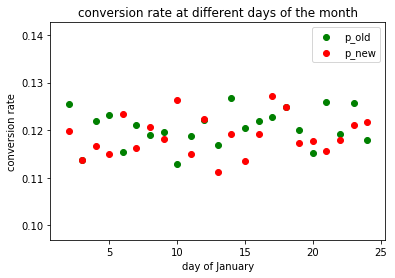

In [103]:
# create a scatter plot to see if there is increase in conversion rate as time goes on
plt.scatter(df2_by_day['day'],  df2_by_day['old_rate'], color='green',label='p_old')
plt.scatter(df2_by_day['day'], df2_by_day['new_rate'], color='red',label='p_new')
plt.xlabel('day of January')
plt.ylabel('conversion rate')
#plt.ylim(0.11, 0.13)
plt.legend()
plt.title('conversion rate at different days of the month');

#### view difference p_new-p_old vs. day,  to see if there is visible correlation

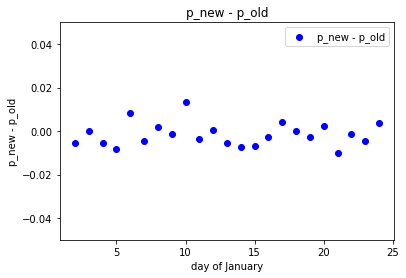

In [104]:
# create a scatter plot to see if there is increase in conversion rate as time goes on
plt.scatter(df2_by_day['day'],  df2_by_day['new_rate']-df2_by_day['old_rate'], color='blue',label='p_new - p_old')
plt.xlabel('day of January')
plt.ylabel('p_new - p_old')
plt.ylim(-0.05, 0.05)
plt.legend()
plt.title('p_new - p_old');

#### run linear regression on p_old and day to see if these is statistically significant change in conversion rate

In [105]:
df2_by_day['intercept']=1
lm=sm.OLS(df2_by_day['old_rate'], df2_by_day[['intercept', 'day']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               old_rate   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.6566
Date:                Fri, 22 Jun 2018   Prob (F-statistic):              0.427
Time:                        16:15:45   Log-Likelihood:                 95.500
No. Observations:                  23   AIC:                            -187.0
Df Residuals:                      21   BIC:                            -184.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1192      0.002     65.201      0.000       0.115       0.123
day            0.0001      0.000      0.810      0.427      -0.000       0.000
==============================================================================
Omnibus:                        1.269   Durbin-Watson:                   2.626
Prob(Omnibus):                  0.530   Jarque-Bera (JB):                0.911
Skew:                          -0.150   Prob(JB):                        0.634
Kurtosis:                       2.073   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### coef=0.0001, p value=0.427, R-square=0.030. All these indicate that there is no statistically significant correlation between p_old and day. Therefore the conversion rate of old page is not changing with running time

#### run linear regression on p_new and day to see if these is statistically significant change in conversion rate

In [106]:
lm=sm.OLS(df2_by_day['new_rate'], df2_by_day[['intercept', 'day']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               new_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.6226
Date:                Fri, 22 Jun 2018   Prob (F-statistic):              0.439
Time:                        16:15:45   Log-Likelihood:                 94.255
No. Observations:                  23   AIC:                            -184.5
Df Residuals:                      21   BIC:                            -182.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1175      0.002     60.919      0.000       0.114       0.122
day            0.0001      0.000      0.789      0.439      -0.000       0.000
==============================================================================
Omnibus:                        0.655   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.695
Skew:                           0.333   Prob(JB):                        0.706
Kurtosis:                       2.470   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### coef=0.0001, p value=0.439, R-square=0.029. All these indicate that there is no statistically significant correlation between p_new and day. Therefore the conversion rate of new page is not changing with running time.

#### run a linear regression to check if p_new-p_old changes over time

In [107]:
lm=sm.OLS(df2_by_day['new_rate']-df2_by_day['old_rate'], df2_by_day[['intercept', 'day']])
results=lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                 0.0002499
Date:                Fri, 22 Jun 2018   Prob (F-statistic):              0.988
Time:                        16:15:45   Log-Likelihood:                 87.310
No. Observations:                  23   AIC:                            -170.6
Df Residuals:                      21   BIC:                            -168.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.003     -0.626      0.538      -0.007       0.004
day         2.826e-06      0.000      0.016      0.988      -0.000       0.000
==============================================================================
Omnibus:                        5.420   Durbin-Watson:                   2.333
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                3.444
Skew:                           0.885   Prob(JB):                        0.179
Kurtosis:                       3.680   Cond. No.                         32.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### R-square =0, coef is 0, p value is close to 1. There is definitely not a statistically significant correlation between p_new-p_old and day.

<a id='conclusions'></a>
## Conclusions

I analyzed user conversion rate vs. their landing_pages. Both A/B testing and logistic regression were employed to answer the same question.

(1) In A/B testing, I performed a one-sided hypothesis testing: whether new page leads to more conversion rate. The null is new page is not better than old page. The alternative is new page is better. The resulted p value from my test is 0.9, therefore I failed to reject null, and conclude that **new page is not better in leading to conversion**.

(2) In the logistic regression method, I intend to prove that conversion rate depends on landing page, therefore it is a two-sided hypothesis test. The null is there is no difference between the conversion rate of old and new page. The alternative is there is a difference. The resulted p value from my test is close to 0.2, therefore I failed to reject null, and conclude that there is no statistically significant difference in conversion rate between old and new landing_page. 

(3) Beside landing_page, I also tested whether country matters in conversion rate. I didn't find any statistically significant evidence that country matters. In other words, **country does not matter**.

(4) I also tried to find out whether day of week matters. When considering all 7 days of weeks, I didn't find statistically significant evidence to support that a specific day of week has better conversion rate. But when comparing Monday and Friday, I did find that **Monday conversion rate is statistically better than Friday**. 

(5) I then tried to find out whether running the test longer time improves conversion rate. Neither old_page nor new_page conversion rate improved with time. From the linear regression of p_new-p_old against day, the R-square=0, and p value is close to 1. Therefore is not any indication that running the test longer will improve test results, and I **DO NOT** suggest running longer time. 

In [108]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0